In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
# from IPython.display import display, Latex
import seaborn as sns

# Data Import

In [15]:
data = pd.read_excel("Data Cleaned.xlsx")
data.columns = ['', 'Operational Cost', 'Profit', 'Revenue', 'Prices']

In [16]:
data.head()

,,Operational Cost,Profit,Revenue,Prices
0,Q1 2012,2613,1396,32445,27760
1,Q2 2012,2735,1040,33211,28668
2,Q3 2012,3073,1631,32172,27414
3,Q4 2012,3465,1546,35731,32312
4,Q1 2013,3141,1611,35649,30711


__Variables__

In [17]:
dataProfit = pd.DataFrame(data.Profit)
dataOC = pd.DataFrame(data["Operational Cost"])
dataRev = pd.DataFrame(data.Revenue)
dataPrices = pd.DataFrame(data.Prices)

In [18]:
for x in [dataProfit, dataOC, dataPrices, dataRev]:
    x["AvgMean(2)"] = x.iloc[:,0].rolling(2).mean()
    x["AvgMean(4)"] = x.iloc[:,0].rolling(4).mean()

## Regression and Graphs

Trend Line Equation for Prices:	127.38x + 30808.29 
Trend Line Equation for Operational Cost:	-16.52x + 2912.02 
Trend Line Equation for Profit:	-48.22x + 1848.41 
Trend Line Equation for Revenue:	48.65x + 35983.84 


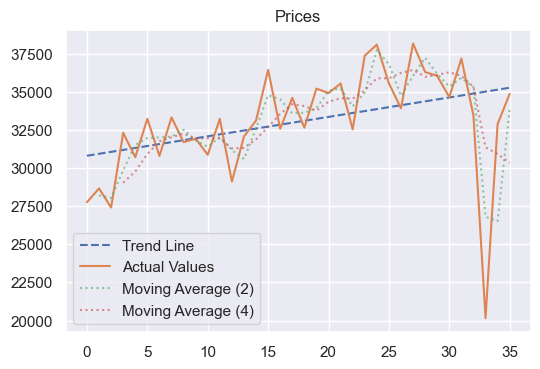

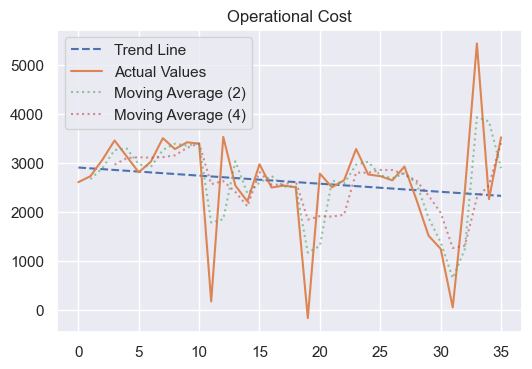

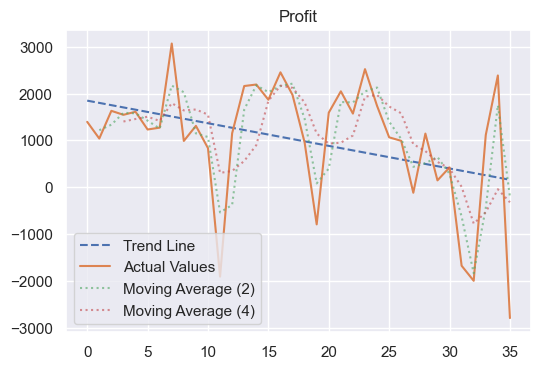

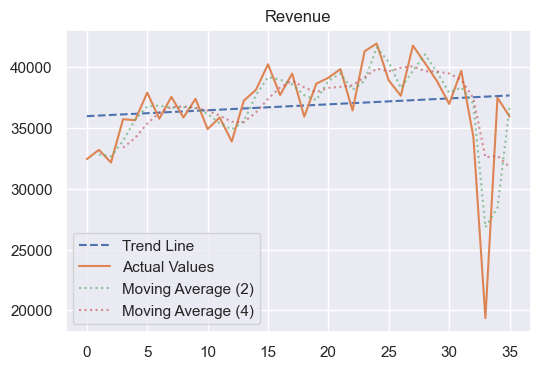

In [19]:
for i in [dataPrices, dataOC, dataProfit, dataRev]:
    z = np.polyfit(np.array(data.index), i.iloc[:,0], 1)
    p = np.poly1d(z)

    fig = plt.figure(dpi = 100)
    sns.set_theme()

    plt.plot(i.index, p(np.array(data.index)), label = "Trend Line", ls = "--")
    plt.plot(i.iloc[:,0], label = "Actual Values")
    plt.plot(i["AvgMean(2)"], label = "Moving Average (2)", linestyle = ":", alpha = 0.618)
    plt.plot(i["AvgMean(4)"], label = "Moving Average (4)", linestyle = ":", alpha = 0.618)
    plt.title(i.columns[0])
    plt.legend()

    print("""Trend Line Equation for {name}:\t{eq} """.format(
        name = i.columns[0], eq = f'{round(p[1], 2)}x + {round(p[0], 2)}'))

#  Decomposition

In [20]:
data['timestamps'] = data[''].str.replace(r'(Q\d) (\d+)', r'\2-\1', regex = True)
data['timestamps'] = pd.PeriodIndex(data.timestamps, freq = 'Q').to_timestamp()

In [21]:
for i in [dataPrices, dataOC, dataProfit, dataRev]:
    i.set_index(data.timestamps, inplace = True)

<Figure size 600x400 with 0 Axes>

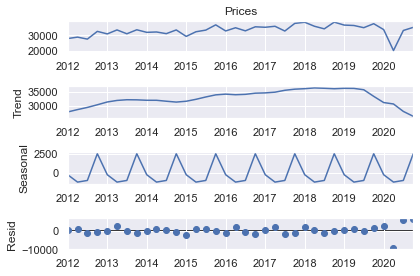

<Figure size 600x400 with 0 Axes>

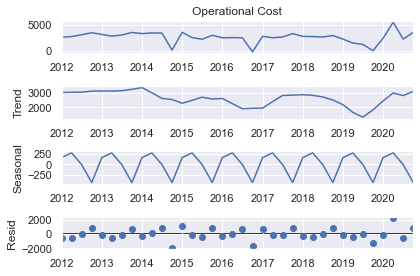

<Figure size 600x400 with 0 Axes>

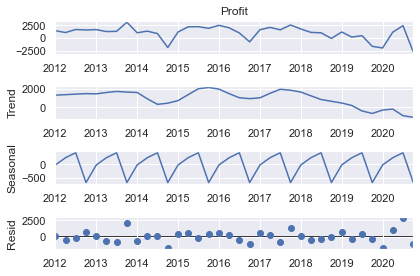

<Figure size 600x400 with 0 Axes>

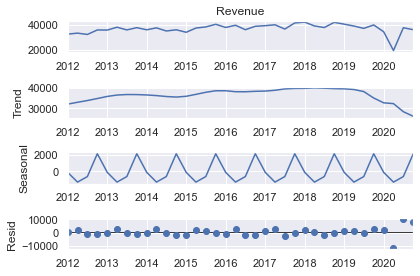

In [22]:
for i, z in zip([dataPrices, dataOC, dataProfit, dataRev], ["Prices", "OC", "Profit", "Revenue"]):
    #additiveModel
    result_add = seasonal_decompose(i.iloc[:,0], model = 'additive', extrapolate_trend= 'freq')
    
    #addValues to the DataFrames:
    i["Trend"] = result_add.trend
    i["Seasonal"] = result_add.seasonal
    i["Residuals"] = result_add.resid

    #Plots
    fig = plt.figure(dpi = 100)
    sns.set_theme()
    result_add.plot()
    plt.savefig(fname = "Plots\\Decomposition_{}.png".format(z), dpi = 200, bbox_inches = 'tight')

#### Data Export

In [23]:
for i in [dataPrices, dataOC, dataProfit, dataRev]:
    fname = i.columns[0]
    i.to_excel(
        f"Data Processed\\Decomposition_{fname}.xlsx"
    )

# SARIMA

In [24]:
import pmdarima as pm

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=605.138, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=602.387, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=603.307, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=603.128, Time=0.04 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=604.330, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=604.230, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=607.994, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=601.424, Time=0.01 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=603.315, Time=0.04 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=605.424, Time=0.06 sec
 ARIMA(2,1,0)(0,1,0)[4]             : AIC=603.264, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=603.251, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=601.242, Time=0.02 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=603.121, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=605.0

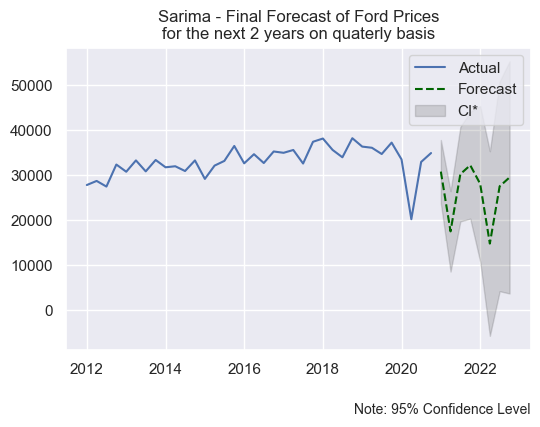

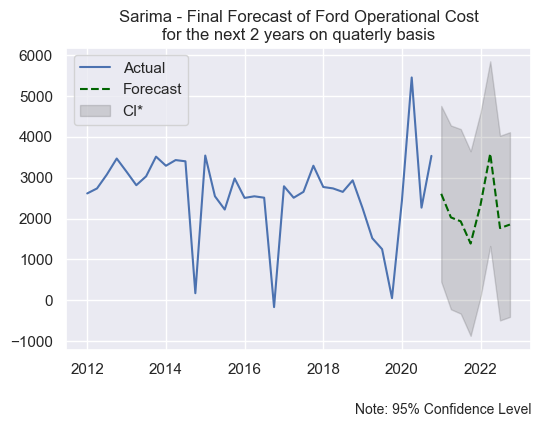

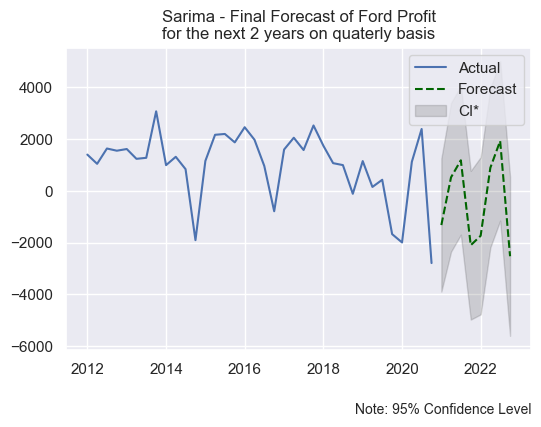

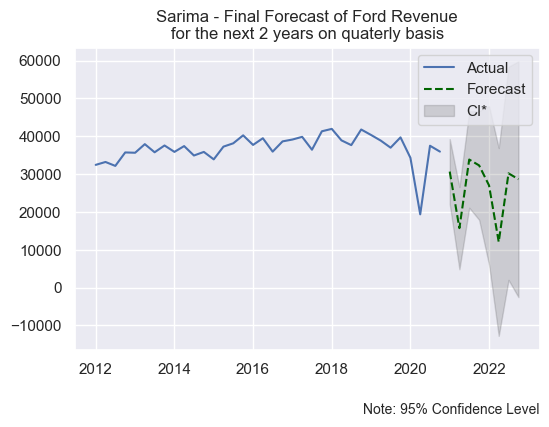

In [77]:
# for i, z in zip([dataPrices, dataOC, dataProfit, dataRev], [1, 2, 3, 4])
mse = {}
for z, i in enumerate([dataPrices, dataOC, dataProfit, dataRev]):
    #modelAlignment
    smodel = pm.auto_arima(i.iloc[:,0], start_p = 1, start_q = 1, test= 'adf',
 max_p = 4, max_q = 4, m = 4, start_P= 0, seasonal = True, d= None, D= 1, alpha = 0.05,
 trace = True, error_action = 'ignore', suppress_warnings = True, stepwise = True)
    print(smodel.summary())

    #Model Fit
    n_periods = int(24/3)
    fitted, confint = smodel.predict(n_periods= n_periods, return_conf_int= True)
    index_of_fc = pd.date_range(i.index[-1], periods = n_periods, freq = 'Q')

    fitted_series = pd.Series(fitted, index = index_of_fc)
    lower_series = pd.Series(confint[:,0], index = index_of_fc)
    upper_series = pd.Series(confint[:,1], index = index_of_fc)

    #MSE
    mse_value = (sum((np.array(smodel.predict_in_sample()) - np.array(i["{}".format(i.columns[0])])**2))/len(i))
    mse["{}".format(i.columns[0])] = mse_value

    #DataFrame to concat to the main df
    df = pd.DataFrame(data = {'Fitted' : fitted_series, 'LowerBound' : lower_series, 'UpperBound' : upper_series}, index = index_of_fc)
    i = pd.concat([i, df], axis = 1)

#     i.to_excel(f"Data Processed\SARIMA_{i.columns[0]}.xlsx")
   
    #Plot
    plt.figure(z, dpi = 100)
    sns.set_theme()
    plt.plot(i.iloc[:,0], label = 'Actual')
    plt.plot(fitted_series, color= 'darkgreen', label = 'Forecast', ls= '--')
    plt.fill_between(lower_series.index, lower_series,upper_series, color= 'k', alpha = 0.15, label = 'CI*')

    plt.annotate('Note: 95% Confidence Level',
            xy = (1.0, -0.2),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)

    plt.legend()
    plt.title(f"Sarima - Final Forecast of Ford {i.columns[0]}\nfor the next 2 years on quaterly basis")
    plt.savefig(fname = "Plots\\SARIMA_{}.png".format(i.columns[0]), dpi = 200, bbox_inches = 'tight')


In [78]:
mse

{'Prices': -1103362044.0830343,
 'Operational Cost': -7938514.216149935,
 'Profit': -2766758.117152185,
 'Revenue': -1371449496.9970367}